# Pipeline Performance Analysis


Load necessary libraries and inputs

In [ ]:
# install.packages("readr")
# install.packages("ggraph")
# install.packages("plotly")
# install.packages("ggExtra")
# install.packages("lubridate")
# install.packages("patchwork")
# install.packages("tidyr")
# install.packages("cowplot")

Installing package into ‘/home/bia/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [268]:
library(readr)       # For reading the trace file
library(ggplot2)     # For creating plots
library(dplyr)       # For data manipulation
library(tidyr)       # For reshaping data
library(ggpubr)      # For arranging multiple plots
library(plotly)      # For interactive plots (optional)
library(igraph)      # For creating flowchart visualizations
library(ggraph)      # For visualizing graph structures
library(RSQLite)
library(DBI)
library(ggExtra)
library(lubridate)
library(patchwork)
library(cowplot)
library(gridExtra)



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [94]:
srr_list <- readLines("../reads_processing/TEST_5SRR_list.txt")
print(srr_list)

[1] "SRR22225469" "SRR28672143" "SRR28872355" "SRR11684912" "SRR24283874"


In [56]:

# Load trace file and sample info (modify the path accordingly)
trace_data <- read_tsv("trace.txt")
head(trace_data)


Rows: 24 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (10): hash, name, status, duration, realtime, %cpu, peak_rss, peak_vmem...
dbl   (3): task_id, native_id, exit
dttm  (1): submit

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,peak_rss,peak_vmem,rchar,wchar
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,29/eca55d,4036,getReadFTP (1),COMPLETED,0,2025-02-17 15:34:27,18.6s,14.7s,5.2%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
4,bd/19bd15,4031,getReadFTP (3),COMPLETED,0,2025-02-17 15:34:26,18.7s,14.7s,5.3%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
3,6f/d7e65f,6065,getReadFTP (2),COMPLETED,0,2025-02-17 15:34:45,5.4s,5.1s,9.6%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
6,3b/e37ae2,6056,getReadFTP (5),COMPLETED,0,2025-02-17 15:34:45,5.5s,5.2s,9.5%,28.1 MB,273.7 MB,4.2 MB,5.8 KB
5,61/9946f0,7606,getReadFTP (4),COMPLETED,0,2025-02-17 15:34:51,41.4s,6s,7.7%,28.2 MB,274.7 MB,4.2 MB,5.8 KB
1,69/86dce2,4027,genomeGenerateSTAR,COMPLETED,0,2025-02-17 15:34:26,2m 59s,2m 52s,114.0%,3.1 GB,4.9 GB,2.2 GB,4.4 GB


Data cleaning

In [ ]:

# Define the function to clean and convert memory/disk usage columns
clean_memory_column <- function(column) {
  # Extract numeric value and unit
  value <- as.numeric(gsub("[^0-9.]", "", column))  # Extract numeric part
  unit <- gsub("[0-9. ]", "", column)  # Extract unit (e.g., "MB", "KB", "GB")

  # Convert all values to MB
  value_mb <- case_when(
    unit == "KB" ~ value / 1024,  # Convert KB to MB
    unit == "MB" ~ value,         # Keep MB as is
    unit == "GB" ~ value * 1024,  # Convert GB to MB
    TRUE ~ NA_real_               # Handle unexpected units
  )

  return(value_mb)
}

# Combine all mutations into a single pipeline
trace_data_filtered <- trace_data %>%
  mutate(
    task_type = gsub(" \\(.*", "", name),
    # Clean duration column
    duration = case_when(
      grepl("m", duration) & grepl("s", duration) ~ {
        minutes <- as.numeric(gsub("m.*", "", duration))
        seconds <- as.numeric(gsub(".*m (\\d+)s.*", "\\1", duration))
        (minutes * 60) + seconds
      },
      grepl("s", duration) & !grepl("m", duration) ~ as.numeric(gsub("s", "", duration)), # nolint
      grepl("m", duration) & !grepl("s", duration) ~ as.numeric(gsub("m", "", duration)) * 60, # nolint
      TRUE ~ NA_real_
    ),

    # Clean %cpu column
    `%cpu` = as.numeric(gsub("%", "", `%cpu`)),

    # Clean memory/disk usage columns
    peak_rss = clean_memory_column(peak_rss),
    peak_vmem = clean_memory_column(peak_vmem),
    rchar = clean_memory_column(rchar),
    wchar = clean_memory_column(wchar)
  ) %>%
  filter(!is.na(duration) & !is.na(`%cpu`)) %>%  # Remove rows with NA in duration or %cpu # nolint
  filter(status == "COMPLETED") %>%  # Keep only completed tasks
  mutate(
    norm_execution_time = duration / max(duration),  # Normalize execution time
    efficiency = `%cpu` / duration,  # Calculate efficiency (CPU% per second)
    task_number = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1", name)),
    SRR = srr_list[task_number],
    


  )

con <- dbConnect(RSQLite::SQLite(), "/home/bia/LandscapeSplicingGrasses/data/grasses.db")
sra_metadata <- dbGetQuery(con, paste(
  "SELECT sra_id, number_of_bases, number_of_spots FROM sra_metadata",
  "WHERE sra_id IN (", paste(shQuote(trace_data_filtered$SRR), collapse = ","), ")"
))
dbDisconnect(con)

trace_data_filtered <- trace_data_filtered %>%
  left_join(sra_metadata, by = c("SRR" = "sra_id")
  )

trace_data_filtered <- trace_data_filtered %>%
  mutate(
    spots_to_bases_ratio = number_of_bases / number_of_spots )

trace_data_filtered <- trace_data_filtered %>%
  mutate(duration_min = duration / 60)

trace_data_filtered <- trace_data_filtered %>%
  mutate(
    peak_rss_norm = peak_rss / number_of_bases,  # Memory per base
    cpu_norm = `%cpu` / number_of_bases          # CPU per base
  )

trace_data_filtered <- trace_data_filtered %>%
  mutate(
    start_time = submit,
    end_time = start_time + seconds(duration),
    task_name = name  # Use unique task names (e.g., "getReadFTP (1)")
  ) %>%
  arrange(start_time) %>%
  mutate(task_name = factor(task_name, levels = unique(task_name)))  # Fix order




# Inspect the cleaned data
str(trace_data_filtered)
head(trace_data_filtered)

Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `duration = case_when(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `task_number = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1",
  name))`.
Caused by warning:
! NAs introduced by coercion”


tibble [22 × 23] (S3: tbl_df/tbl/data.frame)
 $ task_id             : num [1:22] 2 4 3 6 5 1 10 12 9 8 ...
 $ hash                : chr [1:22] "29/eca55d" "bd/19bd15" "6f/d7e65f" "3b/e37ae2" ...
 $ native_id           : num [1:22] 4036 4031 6065 6056 7606 ...
 $ name                : chr [1:22] "getReadFTP (1)" "getReadFTP (3)" "getReadFTP (2)" "getReadFTP (5)" ...
 $ status              : chr [1:22] "COMPLETED" "COMPLETED" "COMPLETED" "COMPLETED" ...
 $ exit                : num [1:22] 0 0 0 0 0 0 0 0 0 0 ...
 $ submit              : POSIXct[1:22], format: "2025-02-17 15:34:27" "2025-02-17 15:34:26" ...
 $ duration            : num [1:22] 18.6 18.7 5.4 5.5 41.4 ...
 $ realtime            : chr [1:22] "14.7s" "14.7s" "5.1s" "5.2s" ...
 $ %cpu                : num [1:22] 5.2 5.3 9.6 9.5 7.7 ...
 $ peak_rss            : num [1:22] 28.1 28.1 28.1 28.1 28.2 ...
 $ peak_vmem           : num [1:22] 274 274 274 274 275 ...
 $ rchar               : num [1:22] 4.2 4.2 4.2 4.2 4.2 ...
 $ wchar  

task_id,hash,native_id,name,status,exit,submit,duration,realtime,%cpu,⋯,wchar,task_type,norm_execution_time,efficiency,task_number,SRR,number_of_bases,number_of_spots,spots_to_bases_ratio,duration_min
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int64>,<int>,<dbl>,<dbl>
2,29/eca55d,4036,getReadFTP (1),COMPLETED,0,2025-02-17 15:34:27,18.6,14.7s,5.2,⋯,5.664062e-03,getReadFTP,0.008161474,0.2795699,1,SRR22225469,6120381900,20401273,300,0.31000000
4,bd/19bd15,4031,getReadFTP (3),COMPLETED,0,2025-02-17 15:34:26,18.7,14.7s,5.3,⋯,5.664062e-03,getReadFTP,0.008205353,0.2834225,3,SRR28872355,6760545300,22535151,300,0.31166667
3,6f/d7e65f,6065,getReadFTP (2),COMPLETED,0,2025-02-17 15:34:45,5.4,5.1s,9.6,⋯,5.664062e-03,getReadFTP,0.002369460,1.7777778,2,SRR28672143,6523122600,21743742,300,0.09000000
6,3b/e37ae2,6056,getReadFTP (5),COMPLETED,0,2025-02-17 15:34:45,5.5,5.2s,9.5,⋯,5.664062e-03,getReadFTP,0.002413339,1.7272727,5,SRR24283874,6499725900,21665753,300,0.09166667
5,61/9946f0,7606,getReadFTP (4),COMPLETED,0,2025-02-17 15:34:51,41.4,6s,7.7,⋯,5.664062e-03,getReadFTP,0.018165862,0.1859903,4,SRR11684912,6794312700,22647709,300,0.69000000
1,69/86dce2,4027,genomeGenerateSTAR,COMPLETED,0,2025-02-17 15:34:26,179.0,2m 52s,114.0,⋯,4.505600e+03,genomeGenerateSTAR,0.078543221,0.6368715,NA,NA,NA,NA,NA,2.98333333


### Resource Consumption Over Time

In [177]:
trace_data_filtered <- trace_data_filtered %>%
  mutate(
    time_min = as.numeric(difftime(submit, min(submit), units = "mins") # Minutos desde o início
  ))

CPU and Memory Usage over Execution Time (Rouhgly)

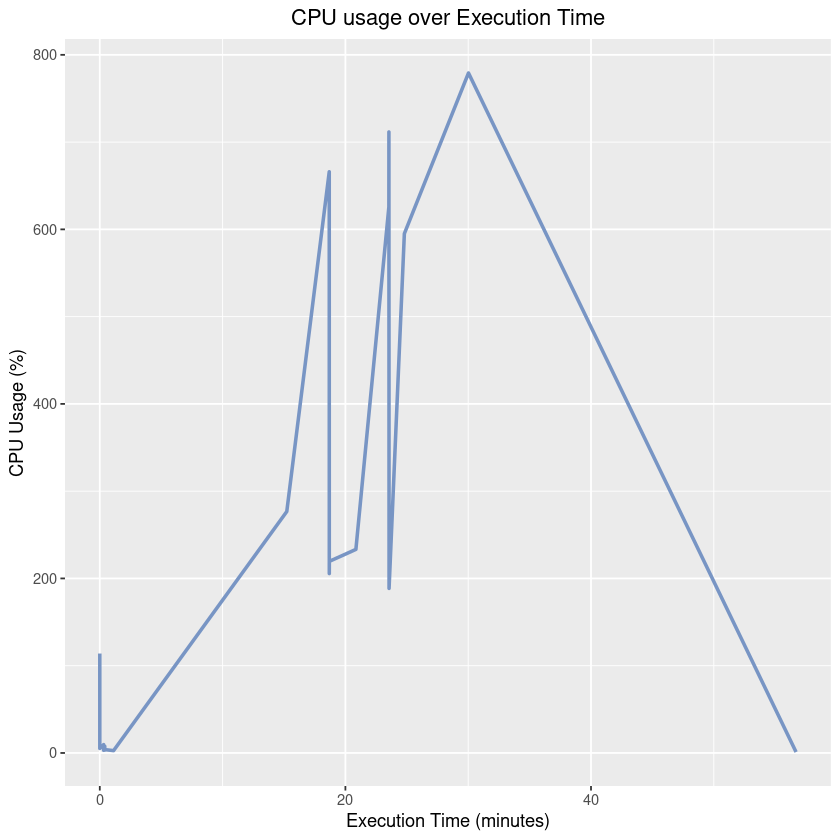

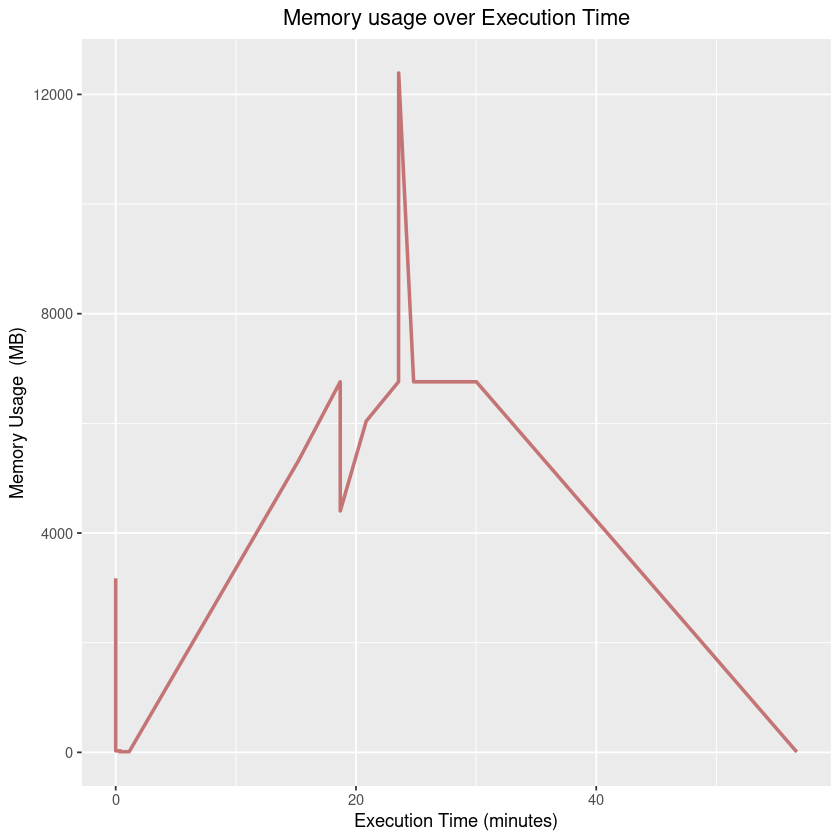

In [205]:
cpu_over_time <- ggplot(trace_data_filtered, aes(x = time_min, y = `%cpu`)) +
  geom_line(color = "#7895c4", linewidth = 1) +
  labs(
    title = "CPU usage over Execution Time",
    x = "Execution Time (minutes)",
    y = "CPU Usage (%)"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) 

mem_over_time <- ggplot(trace_data_filtered, aes(x = time_min, y = peak_rss)) +
geom_line(color = "#c47474", linewidth = 1) +
labs(
  title = "Memory usage over Execution Time",
  x = "Execution Time (minutes)",
  y = "Memory Usage  (MB)"
) +
theme_gray() +
theme(plot.title = element_text(hjust = 0.5))


print(cpu_over_time)
print(mem_over_time)

CPU and Memory Usage over Execution Time (Smoothed)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


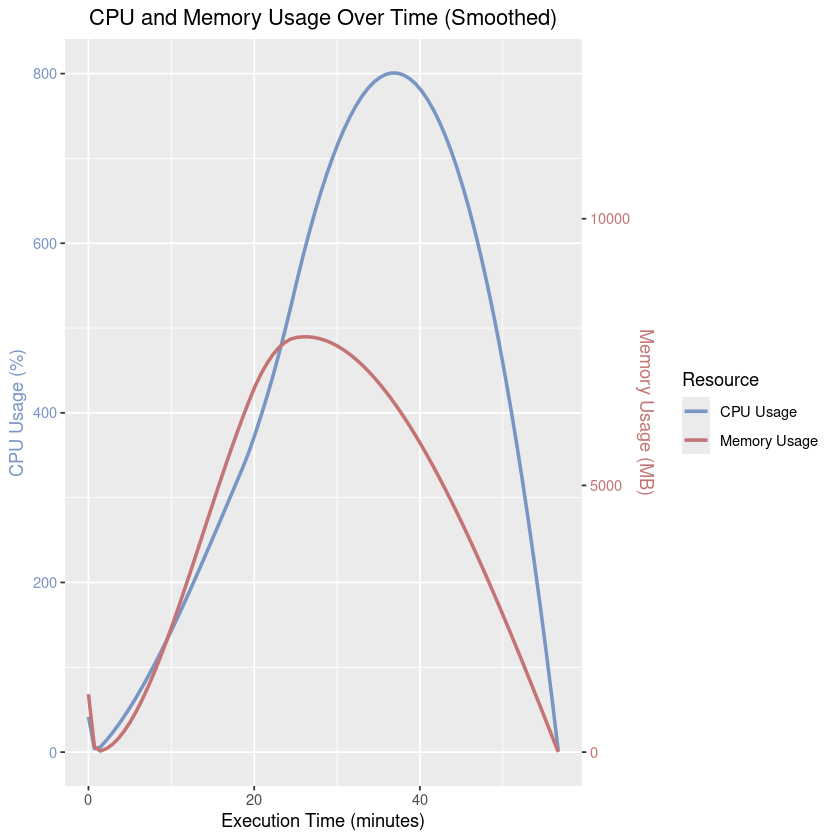

In [206]:

# Compute a scaling factor to align CPU and memory axes (optional but helpful)
scaling_factor <- max(trace_data_filtered$peak_rss) / max(trace_data_filtered$`%cpu`)

# Create the combined plot with smoothed lines and dual y-axes
combined_plot <- ggplot(trace_data_filtered) +
  # CPU usage (left y-axis)
  geom_smooth(
    aes(x = time_min, y = `%cpu`, color = "CPU Usage"),
    method = "loess",
    se = FALSE,
    linewidth = 1,
    span = 0.5
  ) +
  # Memory usage (right y-axis, scaled to match CPU range)
  geom_smooth(
    aes(x = time_min, y = peak_rss / scaling_factor, color = "Memory Usage"),
    method = "loess",
    se = FALSE,
    linewidth = 1,
    span = 0.5
  ) +
  # Dual y-axes
  scale_y_continuous(
    name = "CPU Usage (%)",
    sec.axis = sec_axis(
      ~ . * scaling_factor,  
      name = "Memory Usage (MB)"
    )
  ) +

  scale_color_manual(
    values = c("CPU Usage" = "#7895c4", "Memory Usage" = "#c47474")
  ) +
  labs(
    x = "Execution Time (minutes)",
    color = "Resource",
    title = "CPU and Memory Usage Over Time (Smoothed)"
  ) +
  theme_gray() +
  theme(
    legend.position = "right",
    axis.title.y.right = element_text(color = "#c47474"),
    axis.text.y.right = element_text(color = "#c47474"),
    axis.title.y.left = element_text(color = "#7895c4"),
    axis.text.y.left = element_text(color = "#7895c4"),
    plot.title = element_text(hjust = 0.5))

print(combined_plot)

### Resource Consumption Over Time by Stage

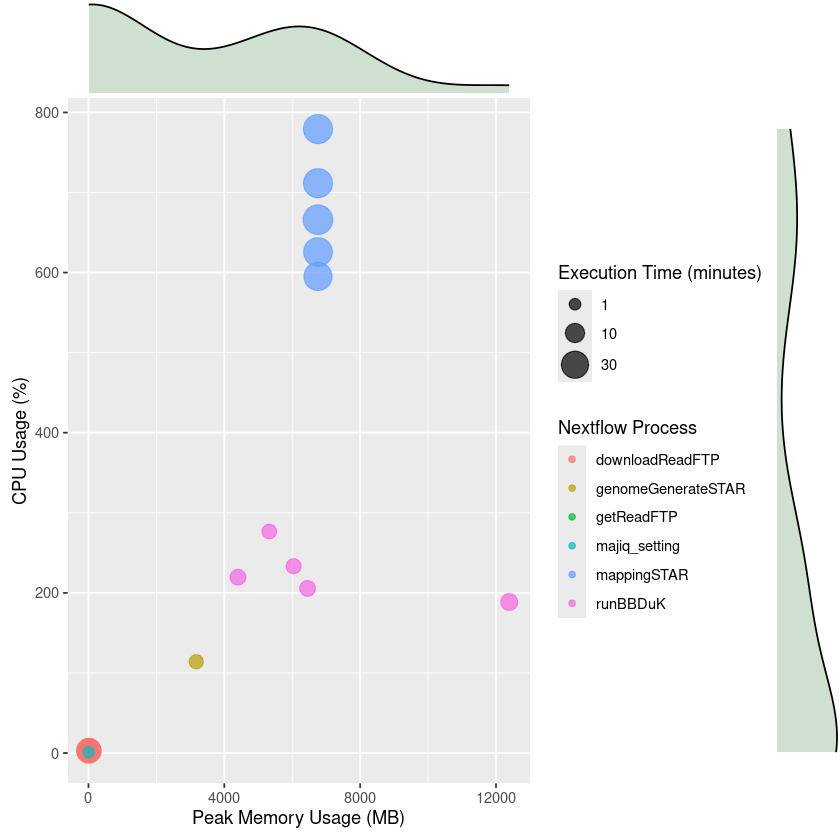

In [248]:
main_plot <- ggplot(trace_data_filtered, aes(x = peak_rss, y = `%cpu`)) +
  geom_point(
    aes(
      color = task_type,  # Color by process
      size = duration_min  # Size by execution time (minutes)
    ),
    alpha = 0.7
  ) +
  scale_size_continuous(
    range = c(2, 8),
    breaks = c(1, 10, 30, 60, 120, 240),
    name = "Execution Time (minutes)"
  ) +
  labs(
    x = "Peak Memory Usage (MB)",
    y = "CPU Usage (%)",
    color = "Nextflow Process"
  ) +
  theme_gray() +
  theme(legend.position = "right")

summary_resource_consumption <- ggMarginal(
main_plot,
type = "density",
margins = "both",
fill = "#bcd3bc",
alpha = 0.7,
size = 7
)


print(summary_resource_consumption)

By Nextflow Process

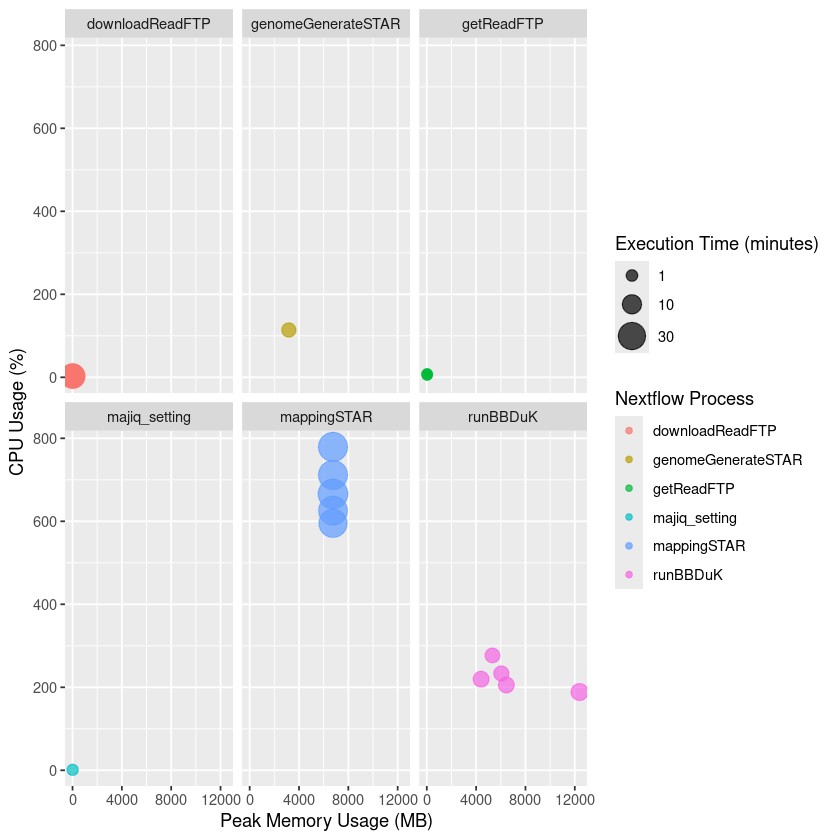

In [ ]:
main_plot +
  facet_wrap(~ task_type)

### Scatter Plot: Resource VS Input SRR length

CPU Usage vs SRR Length


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


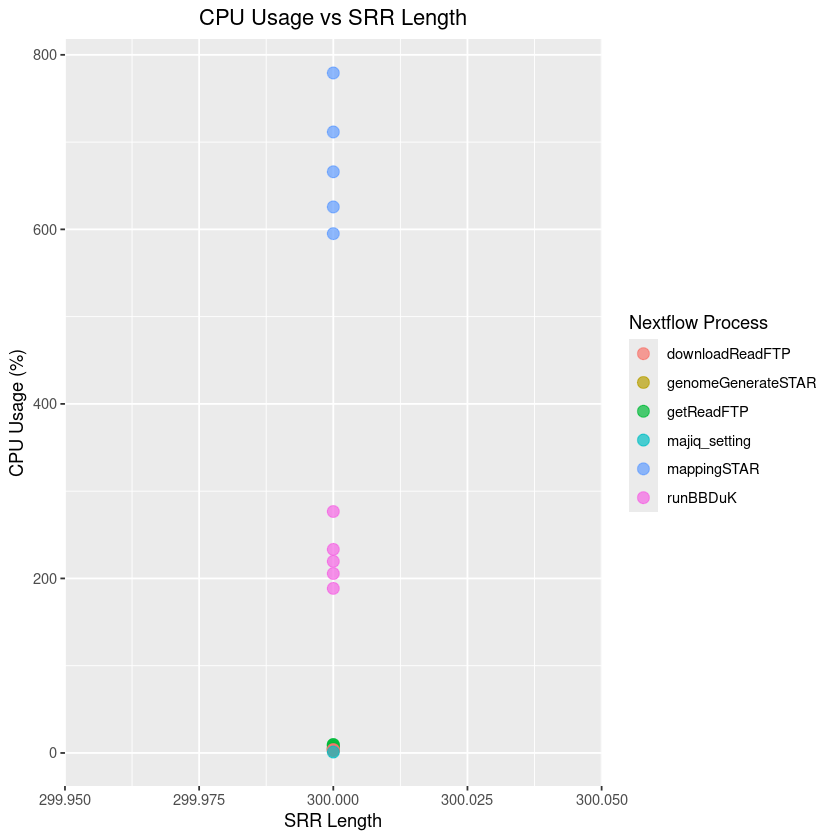

In [ ]:
cpu_plot <- ggplot(trace_data_filtered, aes(x = spots_to_bases_ratio, y = `%cpu`)) +
  geom_point(
    aes(color = task_type),
    size = 3,
    alpha = 0.7
  ) +
  labs(
    x = "SRR Length",
    y = "CPU Usage (%)",
    color = "Nextflow Process",
    title = "CPU Usage vs SRR Length"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) +
  geom_smooth(method = "lm", se = FALSE, color = "black", linetype = "dashed")

print(cpu_plot)

Execution Time vs SRR Length

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


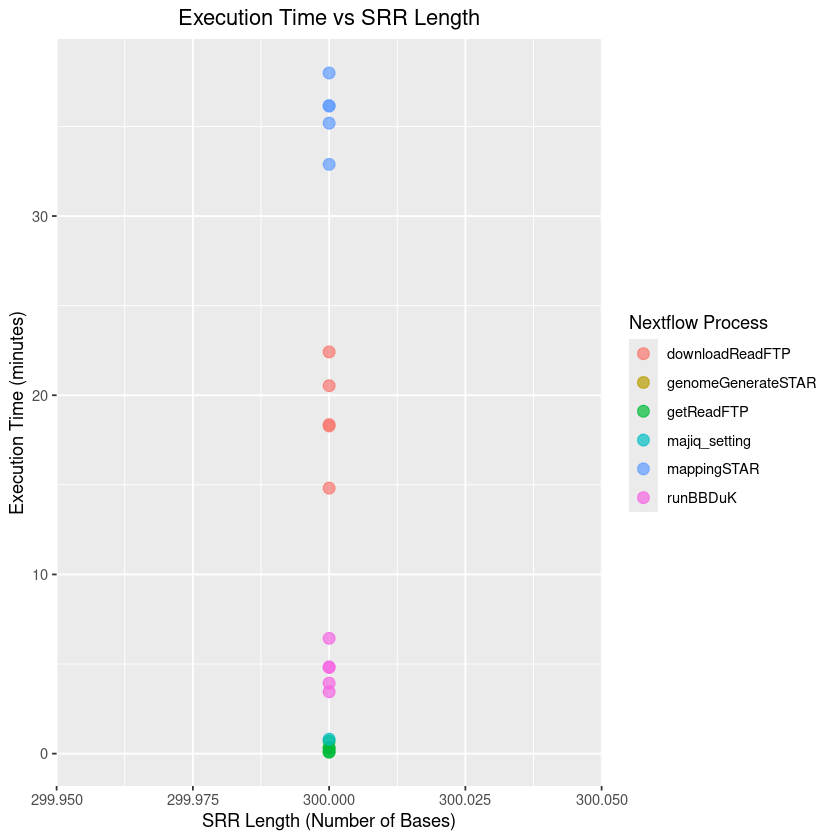

In [ ]:
time_plot <- ggplot(trace_data_filtered, aes(x = spots_to_bases_ratio, y = duration / 60)) +
  geom_point(
    aes(color = task_type),  # Color by process
    size = 3,                # Fixed dot size
    alpha = 0.7
  ) +
  labs(
    x = "SRR Length (Number of Bases)",
    y = "Execution Time (minutes)",
    color = "Nextflow Process",
    title = "Execution Time vs SRR Length"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) +
  geom_smooth(method = "lm", se = FALSE, color = "black", linetype = "dashed")

print(time_plot)

Memory Usage vs SRR Length

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


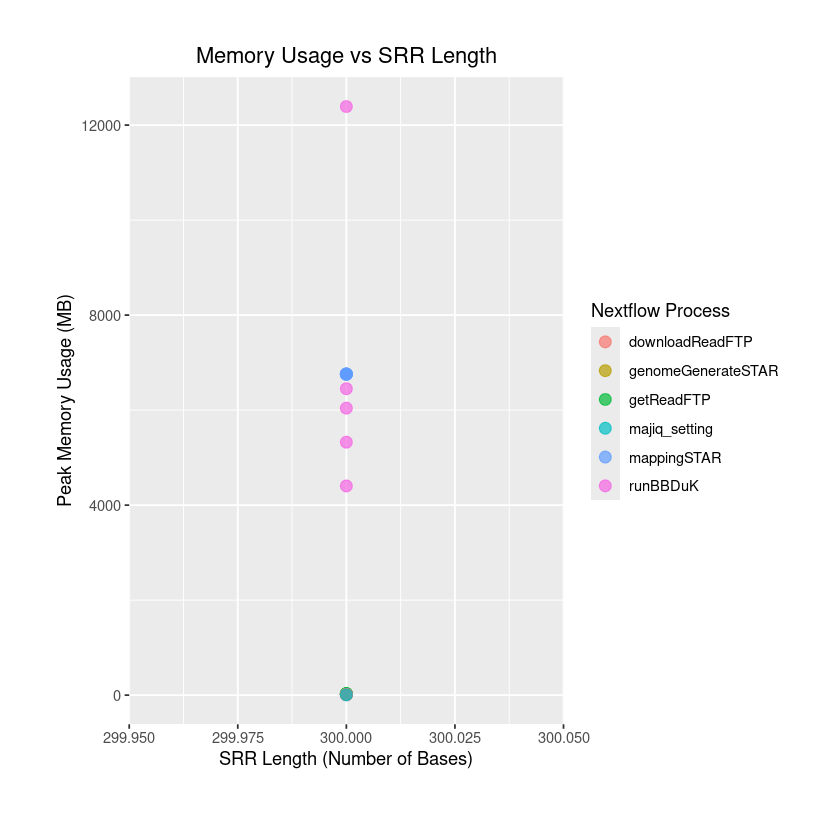

In [ ]:
memory_plot <- ggplot(trace_data_filtered, aes(x = spots_to_bases_ratio, y = peak_rss)) +
  geom_point(
    aes(color = task_type),
    size = 3,
    alpha = 0.7
  ) +
  labs(
    x = "SRR Length (Number of Bases)",
    y = "Peak Memory Usage (MB)",
    color = "Nextflow Process",
    title = "Memory Usage vs SRR Length"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) +
  geom_smooth(method = "lm", se = FALSE, color = "black", linetype = "dashed")


print(memory_plot)

### Resources and Parallelism Analysis through Execution Time

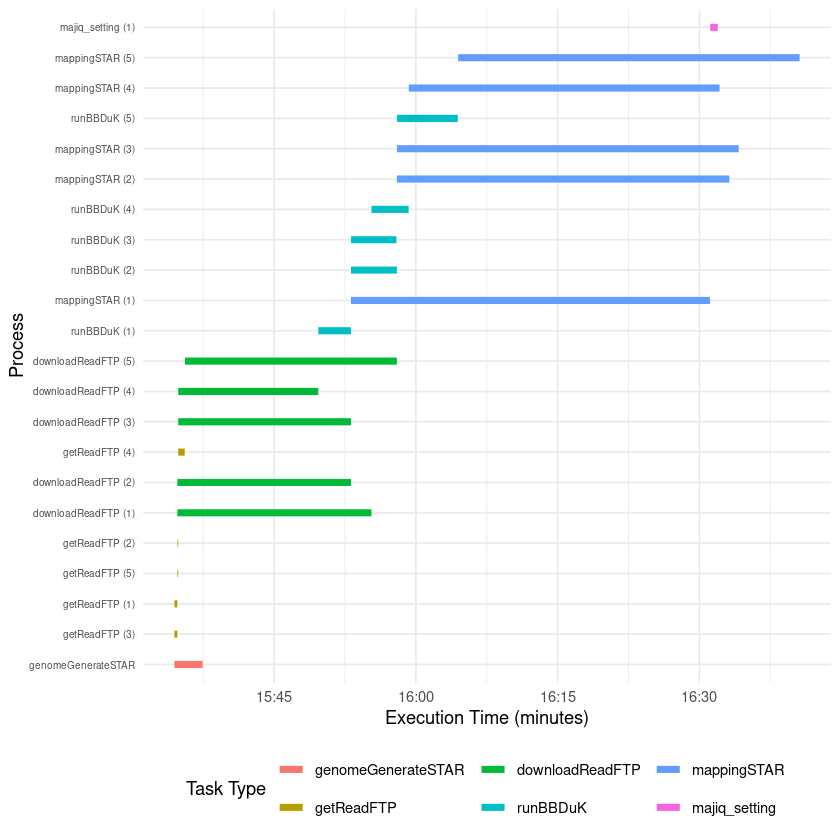

In [280]:
# Gantt chart with execution timelines
gantt_plot <- ggplot(trace_data_filtered) +
  geom_segment(
    aes(
      x = start_time,
      xend = end_time,
      y = task_name,
      yend = task_name,
      color = task_type  # Color by process type
    ),
    linewidth = 2
  ) +
  labs(
    x = "Execution Time (minutes)",
    y = "Process",
    color = "Task Type",
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),  # Adjust for readability
    legend.position = "bottom"
  )

print(gantt_plot)

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.28348”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.2842”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 726.67”
`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse u

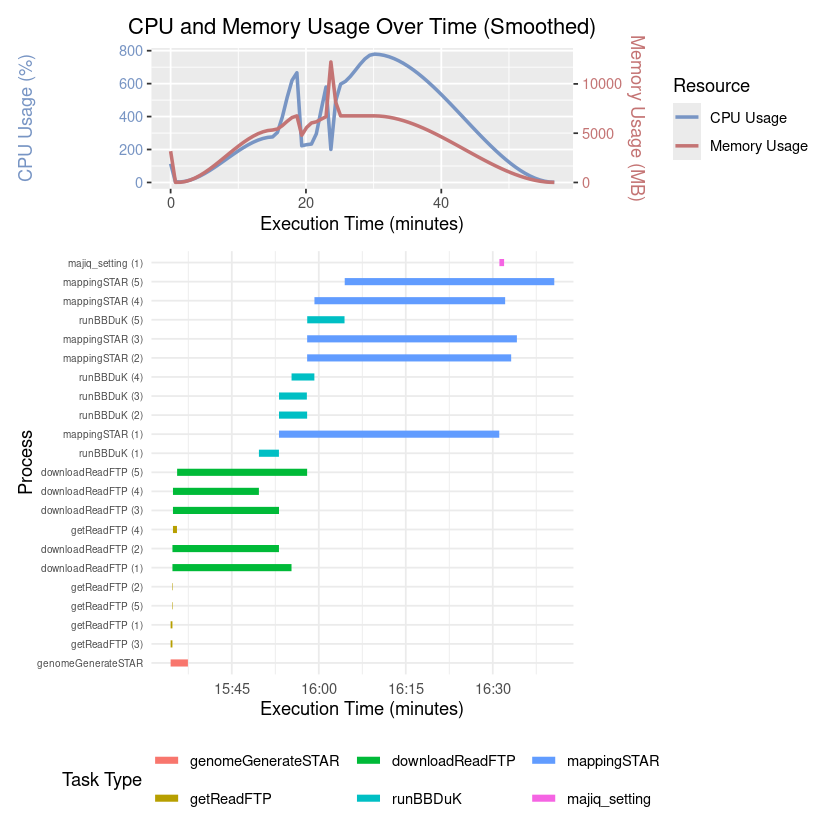

In [283]:
# Calculate parallel tasks per 30-minute bin
parallel_counts <- trace_data_filtered %>%
  mutate(
    time_bin = floor_date(start_time, "30 minutes")  # Bin into 30-minute intervals
  ) %>%
  group_by(time_bin) %>%
  summarize(parallel_tasks = n())

# Create the histogram
histogram_plot <- ggplot(parallel_counts, aes(x = time_bin, y = parallel_tasks)) +
  geom_bar(stat = "identity", fill = "skyblue", alpha = 0.7) +
  labs(
    x = "",
    y = "Parallel Tasks",
    title = "Number of Concurrent Tasks (30-minute bins)"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_blank()  # Hide x-axis labels (shared with Gantt plot)
  )

resource_data <- trace_data_filtered %>%
  mutate(
    time_bin = floor_date(start_time, "30 minutes")
  ) %>%
  group_by(time_bin) %>%
  summarize(
    cpu_usage = sum(`%cpu`, na.rm = TRUE),
    memory_usage = sum(peak_rss, na.rm = TRUE)
  )

# Calculate scaling factor for dual axes
max_cpu <- max(resource_data$cpu_usage)
max_mem <- max(resource_data$memory_usage)
scaling_factor <- max_mem / max_cpu


ai <- ggplot(trace_data_filtered) +
  # CPU usage (left y-axis)
  geom_smooth(
    aes(x = time_min, y = `%cpu`, color = "CPU Usage"),
    method = "loess",
    se = FALSE,
    linewidth = 1,
    span = 0.1
  ) +
  # Memory usage (right y-axis, scaled to match CPU range)
  geom_smooth(
    aes(x = time_min, y = peak_rss / scaling_factor, color = "Memory Usage"),
    method = "loess",
    se = FALSE,
    linewidth = 1,
    span = 0.1
  ) +
  # Dual y-axes
  scale_y_continuous(
    name = "CPU Usage (%)",
    sec.axis = sec_axis(
      ~ . * scaling_factor,  
      name = "Memory Usage (MB)"
    )
  ) +

  scale_color_manual(
    values = c("CPU Usage" = "#7895c4", "Memory Usage" = "#c47474")
  ) +
  labs(
    x = "Execution Time (minutes)",
    color = "Resource",
    title = "CPU and Memory Usage Over Time (Smoothed)"
  ) +
  theme_gray() +
  theme(
    legend.position = "right",
    axis.title.y.right = element_text(color = "#c47474"),
    axis.text.y.right = element_text(color = "#c47474"),
    axis.title.y.left = element_text(color = "#7895c4"),
    axis.text.y.left = element_text(color = "#7895c4"),
    plot.title = element_text(hjust = 0.5))

# Combine with parallel task histogram
combined_top_plot <-  ai



# Combine plots
final_plot <- combined_top_plot / gantt_plot +
  plot_layout(heights = c(1, 3))  # Adjust height ratio

# Display the plot
print(final_plot)

In [ ]:
library(dplyr)
library(lubridate)

# Extract base process name and instance number
trace_data_filtered <- trace_data_filtered %>%
  mutate(
    base_process = gsub(" \\(.*", "", name),  # Extract base process (e.g., "a" from "a (1)")
    instance = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1", name))  # Extract instance number (1, 2, 3, ...)
  )

# Group by base process and calculate start/end times
grouped_data <- trace_data_filtered %>%
  group_by(base_process) %>%
  summarize(
    start_time = min(submit),
    end_time = max(submit + seconds(duration)))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `instance = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1", name))`.
Caused by warning:
! NAs introduced by coercion”


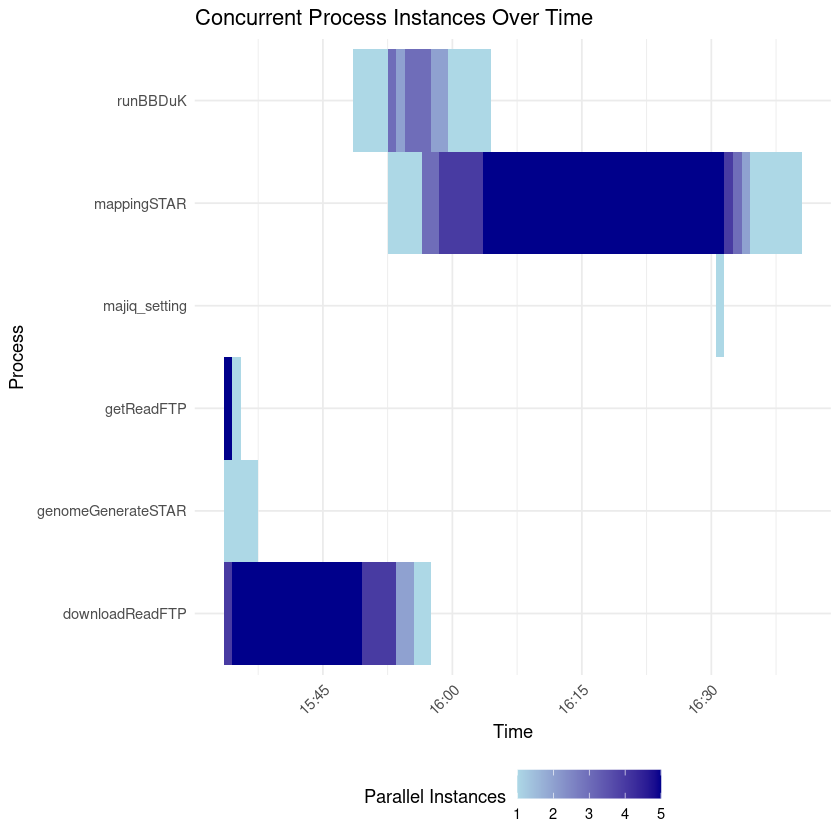

In [172]:
time_bins <- seq(
  floor_date(min(trace_data_filtered$submit), "minute"),
  ceiling_date(max(trace_data_filtered$submit + seconds(trace_data_filtered$duration)), "minute"),
  by = "1 min"
)

# For each process and time bin, count active instances
heatmap_data <- trace_data_filtered %>%
  mutate(
    start_time = submit,
    end_time = submit + seconds(duration)
  ) %>%
  rowwise() %>%
  mutate(
    time_bin = list(seq(
      floor_date(start_time, "minute"),
      floor_date(end_time, "minute"),
      by = "1 min"
    ))
  ) %>%
  unnest(time_bin) %>%
  group_by(base_process, time_bin) %>%
  summarize(active_instances = n(), .groups = "drop")


heatmap_plot <- ggplot(heatmap_data, aes(x = time_bin, y = base_process, fill = active_instances)) +
  geom_tile() +
  scale_fill_gradient(
    low = "lightblue",
    high = "darkblue",
    name = "Parallel Instances"
  ) +
  labs(
    x = "Time",
    y = "Process",
    title = "Concurrent Process Instances Over Time"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "bottom"
  )

print(heatmap_plot)

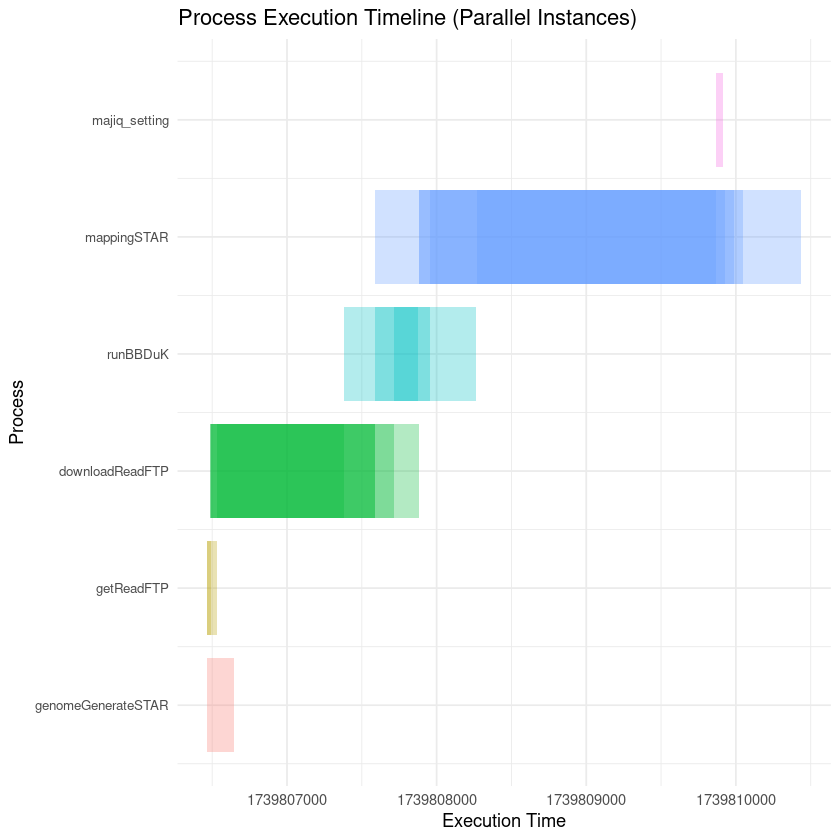

In [174]:
trace_data_filtered <- trace_data_filtered %>%
  mutate(
    base_process = gsub(" \\(.*", "", name),
    base_process = factor(base_process, levels = unique(base_process))  # Fix order
  )

gantt_plot <- ggplot(trace_data_filtered) +
  geom_rect(
    aes(
      xmin = submit,                         # Start time
      xmax = submit + seconds(duration),      # End time
      ymin = as.numeric(base_process) - 0.4,  # Bottom of the row
      ymax = as.numeric(base_process) + 0.4,  # Top of the row
      fill = base_process                     # Color by process type
    ),
    alpha = 0.3  # Transparency to show overlapping instances
  ) +
  scale_y_continuous(
    breaks = seq_along(levels(trace_data_filtered$base_process)),  # Y-axis positions
    labels = levels(trace_data_filtered$base_process)              # Y-axis labels
  ) +
  labs(
    x = "Execution Time",
    y = "Process",
    fill = "Process Type",
    title = "Process Execution Timeline (Parallel Instances)"
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 8),
    legend.position = "none"  # Hide legend if too many processes
  )

print(gantt_plot)

In [ ]:
trace_data_filtered <- trace_data_filtered %>%
  mutate(
    base_process = gsub(" \\(.*", "", name),  # Exemplo: "downloadReadFTP"
    instance = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1", name))  # Número da instância (1, 2, 3, ...)
  ) %>%
  group_by(base_process) %>%
  mutate(
    subprocess_y = cur_group_id() + (instance - 1) * 0.2  # Posição vertical única para cada subprocesso
  ) %>%
  ungroup()

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `instance = as.numeric(gsub(".*\\((\\d+)\\).*", "\\1", name))`.
Caused by warning:
! NAs introduced by coercion”


In [271]:
gantt_plot <- ggplot(trace_data_filtered) +
  geom_rect(
    aes(
      xmin = submit,                          # Início do processo
      xmax = submit + seconds(duration),      # Fim do processo
      ymin = subprocess_y - 0.1,              # Parte inferior do retângulo
      ymax = subprocess_y + 0.1,              # Parte superior do retângulo
      fill = base_process                     # Cor por tipo de processo
    ),
    alpha = 0.7  # Transparência para sobreposições
  ) +
  scale_y_continuous(
    breaks = unique(trace_data_filtered$subprocess_y),  # Posições dos rótulos
    labels = paste0(trace_data_filtered$base_process, " (", trace_data_filtered$instance, ")")  # Rótulos personalizados
  ) +
  labs(
    x = "Tempo de Execução",
    y = "Processo e Instância",
    fill = "Tipo de Processo",
    title = "Linha do Tempo de Execução com Subprocessos Agrupados"
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 8, hjust = 0),  # Ajustar tamanho e alinhamento
    legend.position = "bottom"
  )

print(gantt_plot)

ERROR: [1m[33mError[39m in `scale_y_continuous()`:[22m
[1m[22m[33m![39m `breaks` and `labels` must have the same length.


In [276]:
library(ggplot2)
library(dplyr)

# Calcular o tempo de término
trace_data_filtered <- trace_data_filtered %>%
  mutate(end = submit + duration)

# Criar rótulos únicos para cada tarefa dentro de seu grupo
trace_data_filtered <- trace_data_filtered %>%
  group_by(task_type) %>%
  arrange(submit) %>%  # Ordenar por tempo de submissão dentro do grupo
  mutate(task_label = paste0(task_type, " (", row_number(), ")"),  # Ex: "getReadFTP (1)"
         task_order = row_number()) %>%  # Ordem numérica dentro do grupo
  ungroup() %>%
  mutate(task_label = factor(task_label, levels = unique(task_label)))  # Garantir ordem correta

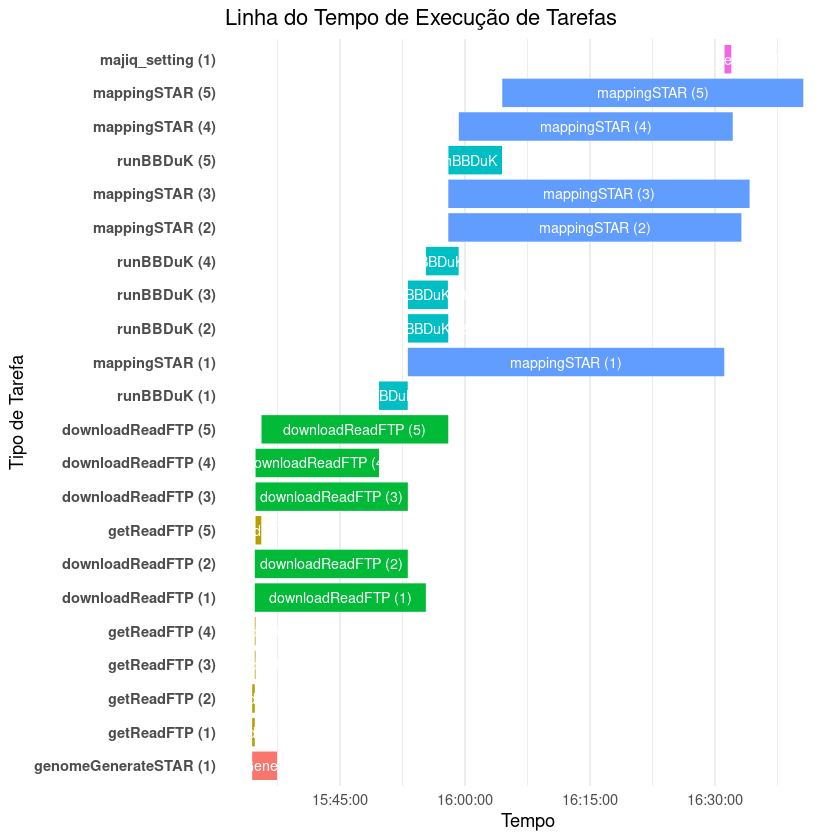

In [279]:
ggplot(trace_data_filtered) +
  geom_segment(
    aes(
      x = submit, 
      xend = end, 
      y = task_label,  # Usar o rótulo único
      yend = task_label, 
      color = task_type
    ), 
    linewidth = 8
  ) +
  geom_text(
    aes(
      x = submit + duration / 2, 
      y = task_label, 
      label = name
    ), 
    color = "white", 
    size = 3, 
    vjust = 0.5
  ) +
  labs(
    x = "Tempo", 
    y = "Tipo de Tarefa", 
    title = "Linha do Tempo de Execução de Tarefas"
  ) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  theme_minimal() +
  theme(
    legend.position = "none",
    panel.grid.major.y = element_blank(),
    axis.text.y = element_text(face = "bold")  # Destacar os rótulos do eixo Y
  )